In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psutil
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, recall_score



In [28]:
# Load dataset (Assuming CSV format)
data = pd.read_csv("UNSW_2018_IoT_Botnet_Final_10_Best.csv", delimiter=';', low_memory=False)

In [29]:

# General dataset information
print(data.head())
print(f"Shape of the dataset: {data.shape}")
print(f"Data types:\n{data.dtypes}")
print("\nDataset Info:")
data.info()


   Unnamed: 0  pkSeqID proto            saddr  sport            daddr dport  \
0           0        1   tcp  192.168.100.147  49960    192.168.100.7    80   
1           1        2   arp    192.168.100.7     -1  192.168.100.147    -1   
2           2        3   tcp  192.168.100.147  49962    192.168.100.7    80   
3           3        4   tcp  192.168.100.147  49964    192.168.100.7    80   
4           4        5   tcp  192.168.100.147  49966    192.168.100.7    80   

   seq    stddev  N_IN_Conn_P_SrcIP       min  state_number      mean  \
0    9  0.068909                 75  0.000000             1  0.068909   
1   10  0.000000                  2  0.000131             2  0.000131   
2   11  0.064494                 75  0.000000             1  0.064494   
3   12  0.064189                 75  0.000000             1  0.064189   
4   13  0.063887                 75  0.000000             1  0.063887   

   N_IN_Conn_P_DstIP      drate     srate       max  attack category  \
0             

In [30]:

# Exploratory Data Analysis (EDA)
print("\nDescriptive Statistics:")
print(data.describe())



Descriptive Statistics:
         Unnamed: 0       pkSeqID           seq        stddev  \
count  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06   
mean   1.834260e+06  1.834262e+06  1.213204e+05  8.871499e-01   
std    1.059011e+06  1.059011e+06  7.579428e+04  8.037139e-01   
min    0.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
25%    9.171302e+05  9.171312e+05  5.487600e+04  3.001900e-02   
50%    1.834260e+06  1.834262e+06  1.177690e+05  7.938960e-01   
75%    2.751391e+06  2.751392e+06  1.849300e+05  1.745296e+00   
max    3.668521e+06  3.668522e+06  2.622120e+05  2.496763e+00   

       N_IN_Conn_P_SrcIP           min  state_number          mean  \
count       3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06   
mean        8.253848e+01  1.017540e+00  3.134390e+00  2.231063e+00   
std         2.439739e+01  1.483688e+00  1.186971e+00  1.517728e+00   
min         1.000000e+00  0.000000e+00  1.000000e+00  0.000000e+00   
25%         6.900000e+01  0.000000e+00 

In [31]:

# Check for missing values and drop rows with null values
missing_values = data.isnull().sum()
print(f"\nMissing values count:\n{missing_values}")
data_cleaned = data.dropna()

# Check distribution of target classes
print("\nTarget Class Distributions:")
print("Attack:\n", data_cleaned["attack"].value_counts())
print("\nCategory:\n", data_cleaned["category"].value_counts())
print("\nSubcategory:\n", data_cleaned["subcategory"].value_counts())


# Analyze the distribution of categorical features
print("\nValue counts for categorical columns:")
print(data_cleaned["proto"].value_counts())
print(data_cleaned["saddr"].value_counts())
print(data_cleaned["sport"].value_counts())
print(data_cleaned["daddr"].value_counts())
print(data_cleaned["dport"].value_counts())
print(data_cleaned["category"].value_counts())
print(data_cleaned["attack"].value_counts())
print(data_cleaned["subcategory"].value_counts())



Missing values count:
Unnamed: 0           0
pkSeqID              0
proto                0
saddr                0
sport                0
daddr                0
dport                0
seq                  0
stddev               0
N_IN_Conn_P_SrcIP    0
min                  0
state_number         0
mean                 0
N_IN_Conn_P_DstIP    0
drate                0
srate                0
max                  0
attack               0
category             0
subcategory          0
dtype: int64

Target Class Distributions:
Attack:
 1    3668045
0        477
Name: attack, dtype: int64

Category:
 DDoS              1926624
DoS               1650260
Reconnaissance      91082
Normal                477
Theft                  79
Name: category, dtype: int64

Subcategory:
 UDP                  1981230
TCP                  1593180
Service_Scan           73168
OS_Fingerprint         17914
HTTP                    2474
Normal                   477
Keylogging                73
Data_Exfiltration       


Encoded target features head:
   attack  category  subcategory
0       1         1            1
1       1         1            1
2       1         1            1
3       1         1            1
4       1         1            1


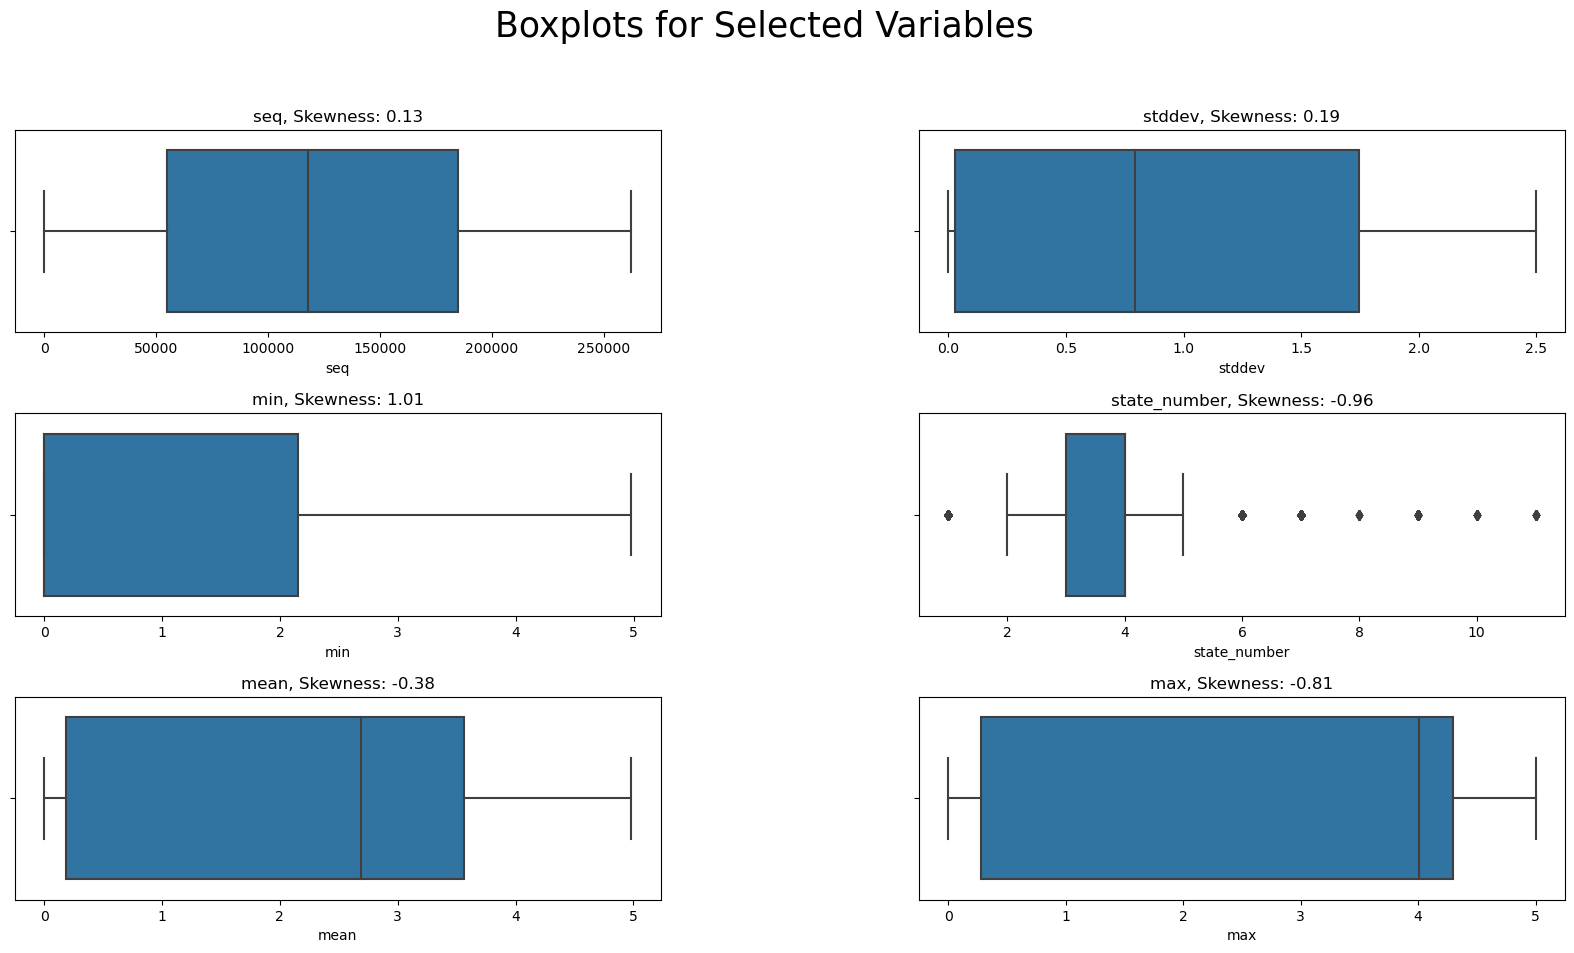

In [18]:
dataset=data_cleaned
# Function to create customized boxplots for features
def create_boxplots(dataset, columns, rows, cols, title):
    fig, axs = plt.subplots(rows, cols, figsize=(20, 10), sharey=True)
    fig.suptitle(title, y=1, fontsize=25)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    axs = axs.flatten()
    for i, col in enumerate(columns):
        sns.boxplot(x=dataset[col], ax=axs[i])
        axs[i].set_title(f'{col}, Skewness: {round(dataset[col].skew(), 2)}')

# Boxplots for selected features
selected_columns = ['seq', 'stddev', 'min', 'state_number', 'mean', 'max']
create_boxplots(data_cleaned, selected_columns, 3, 2, 'Boxplots for Selected Variables')

# Selecting the top 10 features and target columns for model training
selected_features = data_cleaned[['seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max']]
target_features = data_cleaned[['attack', 'category', 'subcategory']]

target_features = pd.DataFrame(target_features)

# Label Encoding for target columns
label_encoder = LabelEncoder()
target_features.loc[:,'category'] = label_encoder.fit_transform(target_features['category'])
target_features.loc[:,'subcategory'] = label_encoder.fit_transform(target_features['subcategory'])

# Checking the transformed target columns
print("\nEncoded target features head:")
print(target_features.head())


In [19]:
X=selected_features
y=target_features

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:


# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Checking for missing values after scaling
missing_count = np.sum(np.isnan(X_train_scaled))
print(f"\nNumber of missing values in the training data after scaling: {missing_count}")



Number of missing values in the training data after scaling: 0


In [21]:
# Function to evaluate model for a single target

def evaluate_model_per_target(X_train, X_test, y_train_col, y_test_col, model, model_name, label_name):
    start_time = time.time()
    process = psutil.Process()
    mem_before = process.memory_info().rss / 1024 ** 2

    model.fit(X_train, y_train_col)
    preds = model.predict(X_test)

    mem_after = process.memory_info().rss / 1024 ** 2
    end_time = time.time()
    execution_time = end_time - start_time
    memory_used = mem_after - mem_before

    acc = accuracy_score(y_test_col, preds)
    recall = recall_score(y_test_col, preds, average='weighted', zero_division=0)
    precision = precision_score(y_test_col, preds, average='weighted', zero_division=0)
    f1 = f1_score(y_test_col, preds, average='weighted', zero_division=0)

    try:
        roc = roc_auc_score(y_test_col, model.predict_proba(X_test), multi_class='ovr')
    except:
        roc = None

    performance[f"{model_name} - {label_name}"] = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC AUC": roc,
        "Execution Time (s)": execution_time,
        "Memory Used (MB)": memory_used
    }

    print(f"\n{model_name} Performance on '{label_name}':")
    print(f"Accuracy: {acc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print(f"ROC AUC: {roc}")
    print(f"Execution Time: {execution_time} seconds")
    print(f"Memory Used: {memory_used} MB\n")

    print("Classification Report:")
    print(classification_report(y_test_col, preds, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_test_col, preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name} - {label_name}')
    plt.show()


In [22]:
# Initialize dictionary to store performance metrics
performance = {}

# Models to train
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', max_depth=6, subsample=0.8, colsample_bytree=0.8, n_jobs=-1),
    #"SVM": SVC(kernel='rbf', probability=True)    
}



Random Forest Performance on 'attack':
Accuracy: 0.9999672893056474
Precision: 0.9999672903757404
Recall: 0.9999672893056474
F1-Score: 0.9999649249446676
ROC AUC: None
Execution Time: 80.45655870437622 seconds
Memory Used: 4.6171875 MB

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        95
           1       1.00      1.00      1.00    733610

    accuracy                           1.00    733705
   macro avg       1.00      0.87      0.93    733705
weighted avg       1.00      1.00      1.00    733705



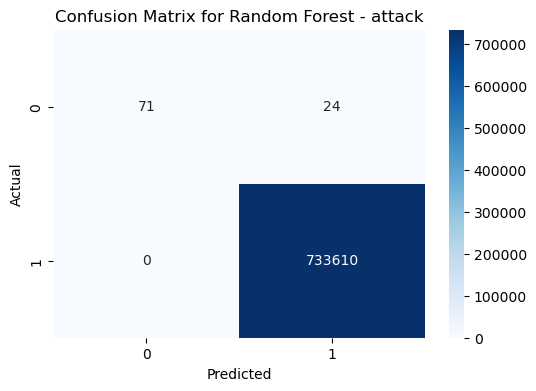


XGBoost Performance on 'attack':
Accuracy: 0.9999945482176079
Precision: 0.9999946325198055
Recall: 0.9999945482176079
F1-Score: 0.9999945766085924
ROC AUC: None
Execution Time: 6.972315073013306 seconds
Memory Used: 41.109375 MB

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        95
           1       1.00      1.00      1.00    733610

    accuracy                           1.00    733705
   macro avg       0.98      0.99      0.99    733705
weighted avg       1.00      1.00      1.00    733705



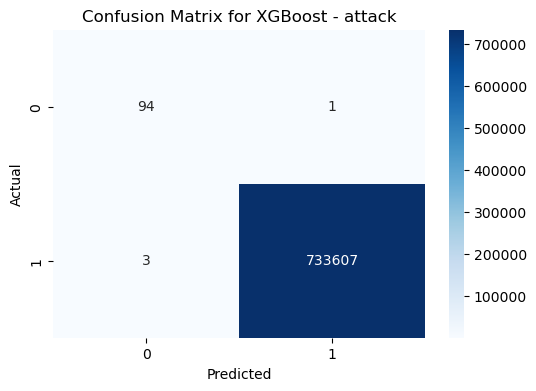


Random Forest Performance on 'category':
Accuracy: 0.9943437757681902
Precision: 0.9943464040120745
Recall: 0.9943437757681902
F1-Score: 0.9943421846395257
ROC AUC: 0.9999568347064505
Execution Time: 102.80150270462036 seconds
Memory Used: 11.203125 MB

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    385325
           1       1.00      0.99      0.99    330052
           2       1.00      0.83      0.91        95
           3       1.00      1.00      1.00     18217
           4       1.00      0.94      0.97        16

    accuracy                           0.99    733705
   macro avg       1.00      0.95      0.97    733705
weighted avg       0.99      0.99      0.99    733705



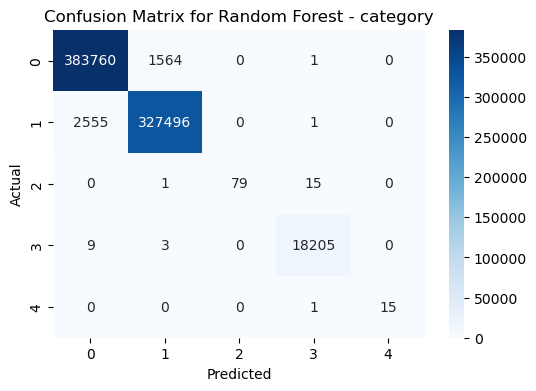


XGBoost Performance on 'category':
Accuracy: 0.9997110555332184
Precision: 0.9997111890030552
Recall: 0.9997110555332184
F1-Score: 0.9997110575672233
ROC AUC: 0.9999997558108408
Execution Time: 47.45628380775452 seconds
Memory Used: 50.1484375 MB

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    385325
           1       1.00      1.00      1.00    330052
           2       1.00      0.99      0.99        95
           3       1.00      1.00      1.00     18217
           4       1.00      1.00      1.00        16

    accuracy                           1.00    733705
   macro avg       1.00      1.00      1.00    733705
weighted avg       1.00      1.00      1.00    733705



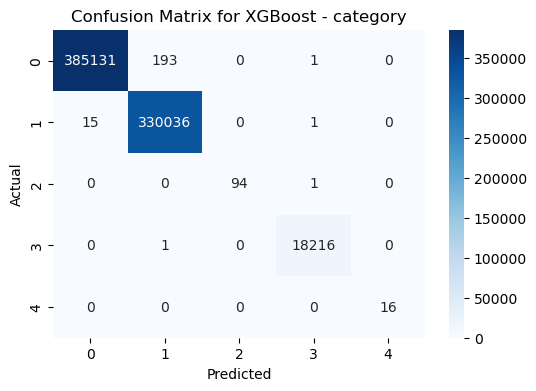


Random Forest Performance on 'subcategory':
Accuracy: 0.9977497768176583
Precision: 0.9978567424982108
Recall: 0.9977497768176583
F1-Score: 0.9975233765905752
ROC AUC: 0.9998971523958302
Execution Time: 83.98737525939941 seconds
Memory Used: -34.89453125 MB

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      0.98      0.99       495
           2       1.00      0.20      0.33        15
           3       1.00      0.81      0.90        95
           4       0.96      0.58      0.72      3583
           5       0.90      0.99      0.95     14634
           6       1.00      1.00      1.00    318636
           7       1.00      1.00      1.00    396246

    accuracy                           1.00    733705
   macro avg       0.86      0.70      0.74    733705
weighted avg       1.00      1.00      1.00    733705



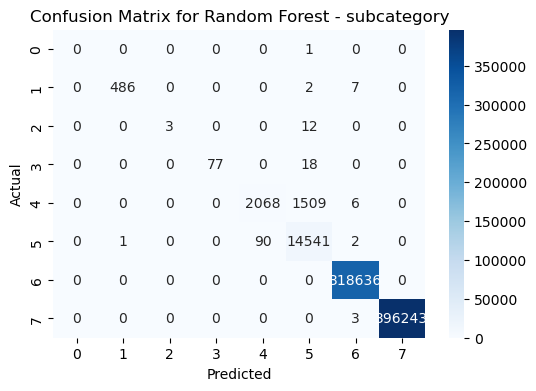


XGBoost Performance on 'subcategory':
Accuracy: 0.998762445396992
Precision: 0.9987488402895721
Recall: 0.998762445396992
F1-Score: 0.9987537699061099
ROC AUC: 0.999967389881445
Execution Time: 62.37513446807861 seconds
Memory Used: 52.2109375 MB

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      0.99      0.99       495
           2       1.00      1.00      1.00        15
           3       0.99      0.99      0.99        95
           4       0.89      0.86      0.87      3583
           5       0.97      0.97      0.97     14634
           6       1.00      1.00      1.00    318636
           7       1.00      1.00      1.00    396246

    accuracy                           1.00    733705
   macro avg       0.98      0.98      0.98    733705
weighted avg       1.00      1.00      1.00    733705



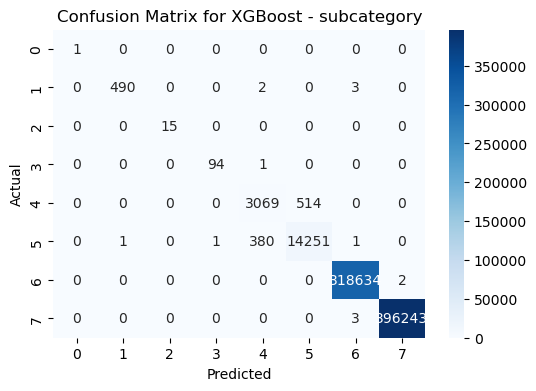

In [23]:

# Train each model for each target
for label in y_train.columns:
    for model_name, model in models.items():
        evaluate_model_per_target(
            X_train, X_test,
            y_train[label], y_test[label],
            model, model_name, label
        )

        


Model Performance Summary:
                             Accuracy  Precision    Recall  F1-Score  \
Random Forest - attack       0.999967   0.999967  0.999967  0.999965   
XGBoost - attack             0.999995   0.999995  0.999995  0.999995   
Random Forest - category     0.994344   0.994346  0.994344  0.994342   
XGBoost - category           0.999711   0.999711  0.999711  0.999711   
Random Forest - subcategory  0.997750   0.997857  0.997750  0.997523   
XGBoost - subcategory        0.998762   0.998749  0.998762  0.998754   

                              ROC AUC  Execution Time (s)  Memory Used (MB)  
Random Forest - attack            NaN           80.456559          4.617188  
XGBoost - attack                  NaN            6.972315         41.109375  
Random Forest - category     0.999957          102.801503         11.203125  
XGBoost - category           1.000000           47.456284         50.148438  
Random Forest - subcategory  0.999897           83.987375        -34.894531  

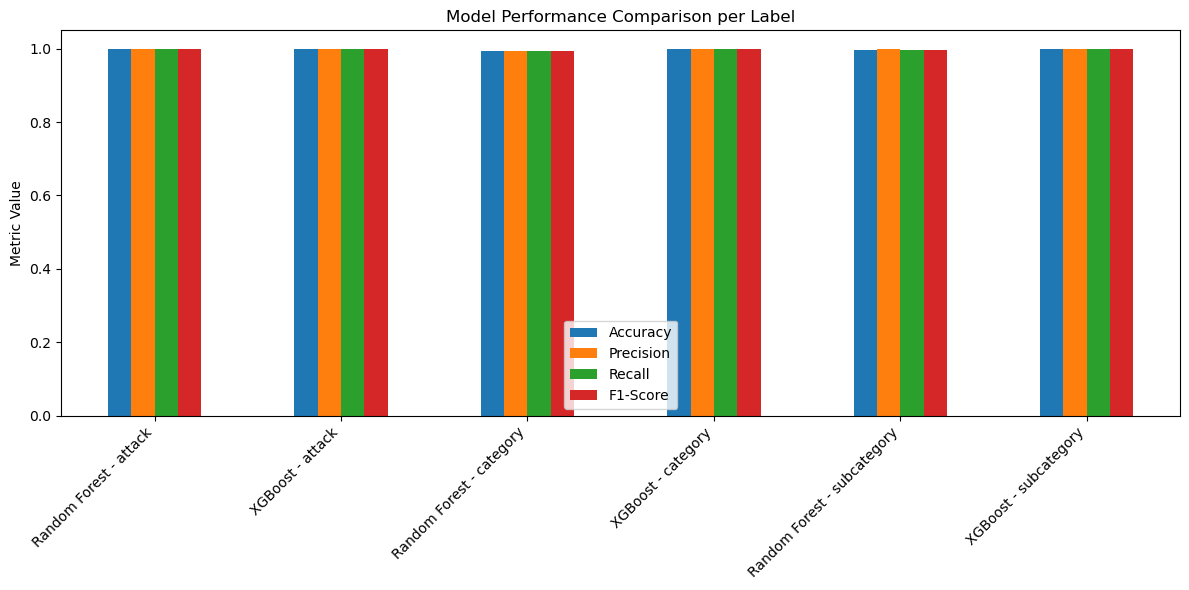

In [24]:
# Convert performance results into a DataFrame
performance_df = pd.DataFrame(performance).T

# Show table
print("\nModel Performance Summary:")
print(performance_df)

# Bar plot of key metrics
performance_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(kind='bar', figsize=(12, 6))
plt.title("Model Performance Comparison per Label")
plt.ylabel("Metric Value")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
